# Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle, re, requests, json, os
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix # Import csr_matrix
from sklearn.ensemble import RandomForestClassifier  # Importing RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier  # Importing DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

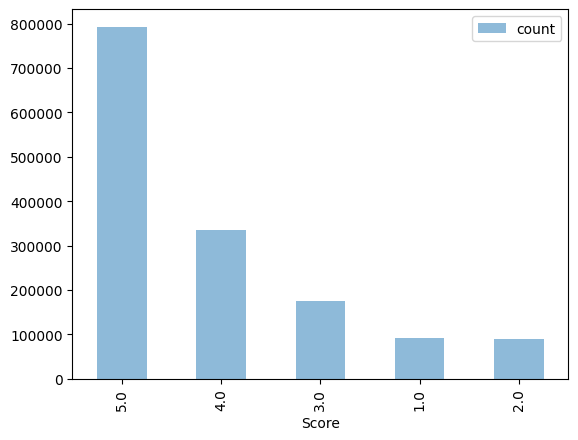


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [4]:
trainingSet = pd.read_csv("datasets/train.csv")
testingSet = pd.read_csv("datasets/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [53]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    return df

# Load the feature extracted files if they've already been generated
if exists('datasets/X_train.csv'):
    X_training = pd.read_csv("datasets/X_train.csv")
if exists('datasets/X_submission.csv'):
    X_submission = pd.read_csv("datasets/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_training =  train[train['Score'].notnull()]

    X_submission.to_csv("datasets/X_submission.csv", index=False)
    X_training.to_csv("datasets/X_train.csv", index=False)

# Sample + Split into training and testing set

In [34]:
#Fill NaN values in 'Text' column
X_training['Text'].fillna('', inplace=True)

# Split the data into training and testing sets
y_train = X_training['Score']
X_train = X_training.drop(['Score'], axis=1)

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

<ipython-input-34-e778c5d93958>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_training['Text'].fillna('', inplace=True)


In [35]:
X_train.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Helpfulness,UserFrequency,ProductFrequency,SummarySentimentScore,SummarySentiment,TextSentimentScore,TextSentiment,Year,Month,Day
0,849388,B0002XVKMC,A1EYS0SF2CWUQJ,3,8,2006-06-09,The Final Season!,"""Buffy"" is my favorite TV show of all time and...",0.375,1,1,0.0000,neutral,0.9659,very positive,2006,6,9
1,643839,B00005JOY9,A3EW4F5K3P0XA4,0,0,2014-02-25,great buy,"i bought this movie because i was buying 1,2, ...",0.000,1,2,0.6249,very positive,0.4404,positive,2014,2,25
2,168859,1404974725,A2HWLC7ISWYNTI,0,0,2013-01-14,Absolutely Fantastic,This is such a funny movie! I love Jim Carrey...,0.000,1,1,0.5984,positive,0.8264,very positive,2013,1,14
3,1518032,B006OFN052,A1D3BMPIUZ8V34,0,0,2012-03-19,it was as stated,not a copy all origanal package.no problems go...,0.000,1,3,0.0000,neutral,0.1260,neutral,2012,3,19
4,1268348,B002GYHIYE,A5LNJ2CVLXFK3,0,0,2014-02-09,DVD,This is the most outstanding DVD. It makes on...,0.000,1,1,0.0000,neutral,0.8357,very positive,2014,2,9


# Feature Selection

In [50]:
selected_features = ['Summary', 'Text', 'Helpfulness']

# Keep only the selected features in X_train_split and X_test_split
X_train_split = X_train_split[selected_features]
X_test_split = X_test_split[selected_features]

# Also, apply the same feature selection to the X_submission DataFrame
X_submission_select = X_submission[selected_features]

# Preprocess Data

In [68]:
# Initialize TF-IDF Vectorizer for the 'Text' column
tfidf_text = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the text data for the 'Text' column
X_train_tfidf_text = tfidf_text.fit_transform(X_train_split['Text'])
X_test_tfidf_text = tfidf_text.transform(X_test_split['Text'])
X_submission['Text'] = X_submission['Text'].fillna('')
X_submission_tfidf_text = tfidf_text.transform(X_submission['Text'])

# Initialize TF-IDF Vectorizer for the 'Summary' column
tfidf_summary = TfidfVectorizer(stop_words='english', max_features=5000)

# Fill NaN values in 'Summary' column with empty strings before applying fit_transform
# This is done for X_train_split, X_test_split, and X_submission
X_train_split['Summary'] = X_train_split['Summary'].fillna('')
X_test_split['Summary'] = X_test_split['Summary'].fillna('')
X_submission['Summary'] = X_submission['Summary'].fillna('')

# Fit and transform the text data for the 'Summary' column
X_train_tfidf_summary = tfidf_summary.fit_transform(X_train_split['Summary'])
X_test_tfidf_summary = tfidf_summary.transform(X_test_split['Summary'])
X_submission_tfidf_summary = tfidf_summary.transform(X_submission['Summary'])

# Apply TruncatedSVD on the text features
svd_text = TruncatedSVD(n_components=250, random_state=0)
X_train_text_reduced = svd_text.fit_transform(X_train_tfidf_text)
X_test_text_reduced = svd_text.transform(X_test_tfidf_text)
X_submission_text_reduced = svd_text.transform(X_submission_tfidf_text)

# Apply TruncatedSVD on the summary features
svd_summary = TruncatedSVD(n_components=250, random_state=0)
X_train_summary_reduced = svd_summary.fit_transform(X_train_tfidf_summary)
X_test_summary_reduced = svd_summary.transform(X_test_tfidf_summary)
X_submission_summary_reduced = svd_summary.transform(X_submission_tfidf_summary)

# Convert to csr_matrix before stacking
X_train_text_reduced = csr_matrix(X_train_text_reduced)
X_train_summary_reduced = csr_matrix(X_train_summary_reduced)
X_test_text_reduced = csr_matrix(X_test_text_reduced)
X_test_summary_reduced = csr_matrix(X_test_summary_reduced)
X_submission_text_reduced = csr_matrix(X_submission_text_reduced)
X_submission_summary_reduced = csr_matrix(X_submission_summary_reduced)

# Combine the reduced features from text and summary
X_train_combined = hstack([X_train_text_reduced, X_train_summary_reduced])
X_test_combined = hstack([X_test_text_reduced, X_test_summary_reduced])
X_submission_combined = hstack([X_submission_text_reduced, X_submission_summary_reduced])

# Additional Models (not used)

In [62]:
# Initialize the Random Forest model with hyperparameters
model2 = RandomForestClassifier(
    n_estimators=50,       # Number of trees in the forest
    max_depth=10,         # Maximum depth of the trees
    min_samples_split=4,    # Minimum number of samples required to split an internal node
    min_samples_leaf=2,     # Minimum number of samples required to be at a leaf node
    max_features='sqrt',    # Changed from 'auto' to 'sqrt'
    random_state=42          # Seed for reproducibility
)

# Fit the model to the training data
model2.fit(X_train_combined, y_train_split)

# Predict on the training set
train_predictions = model2.predict(X_train_combined)

# Calculate and print the accuracy on the training set
train_accuracy = accuracy_score(y_train_split, train_predictions)
print(f"Training Set Accuracy: {train_accuracy}")

# Predict on the testing set
Y_test_predictions = model2.predict(X_test_combined)

# Calculate and print the accuracy on the testing set
test_accuracy = accuracy_score(y_test_split, Y_test_predictions)
print(f"Testing Set Accuracy: {test_accuracy}")

# Print the confusion matrix for more detailed evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test_split, Y_test_predictions))

Training Set Accuracy: 0.637375
Testing Set Accuracy: 0.541
Confusion Matrix:
[[   0    0    0    2  110]
 [   0    0    0    8   98]
 [   0    0    1    9  251]
 [   0    0    0   10  437]
 [   0    0    0    3 1071]]


In [64]:
# Initialize the Decision Tree model with hyperparameters
model3 = DecisionTreeClassifier(
    max_depth=10,           # Limit the maximum depth of the tree
    min_samples_split=5,    # Minimum number of samples required to split an internal node
    min_samples_leaf=2,     # Minimum number of samples required to be at a leaf node
    random_state=42          # Seed for reproducibility
)

# Fit the model to the training data
model3.fit(X_train_combined, y_train_split)

# Cross-Validation to check performance
cv_scores = cross_val_score(model3, X_train_combined, y_train_split, cv=5)
print(f"Cross-Validation Accuracy: {np.mean(cv_scores)}")

# Predict on the training set
train_predictions = model3.predict(X_train_combined)

# Calculate and print the accuracy on the training set
train_accuracy = accuracy_score(y_train_split, train_predictions)
print(f"Training Set Accuracy: {train_accuracy}")

# Predict on the testing set
Y_test_predictions = model3.predict(X_test_combined)

# Calculate and print the accuracy on the testing set
test_accuracy = accuracy_score(y_test_split, Y_test_predictions)
print(f"Testing Set Accuracy: {test_accuracy}")

# Print the confusion matrix for more detailed evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test_split, Y_test_predictions))


Cross-Validation Accuracy: 0.45424999999999993
Training Set Accuracy: 0.737
Testing Set Accuracy: 0.466
Confusion Matrix:
[[ 16  12  10  28  46]
 [  8   5  16  26  51]
 [  7  13  31  81 129]
 [ 20  14  25 104 284]
 [ 22  18  46 212 776]]


# Model Creation (final model)

In [69]:
# Prepare Helpfulness for model training
X_train_helpfulness = csr_matrix(X_train_split['Helpfulness'].values.reshape(-1, 1))
X_test_helpfulness = csr_matrix(X_test_split['Helpfulness'].values.reshape(-1, 1))
X_submission_helpfulness = csr_matrix(X_submission['Helpfulness'].values.reshape(-1, 1))

# Combine Text, Summary, and Helpfulness features
X_train_combined = hstack([X_train_text_reduced, X_train_summary_reduced, X_train_helpfulness])
X_test_combined = hstack([X_test_text_reduced, X_test_summary_reduced, X_test_helpfulness])
X_submission_combined = hstack([X_submission_text_reduced, X_submission_summary_reduced, X_submission_helpfulness])

# Convert X_train_combined to CSR format for efficient row slicing
X_train_combined = X_train_combined.tocsr()

# Drop rows with NaN values in y_train_split and reset index
y_train_split = y_train_split.dropna().reset_index(drop=True)

# Drop corresponding rows from X_train_combined based on the updated y_train_split index
X_train_combined = X_train_combined[y_train_split.index]

# Assuming y_test_split also needs to drop NaN and reset index for consistency
y_test_split = y_test_split.dropna().reset_index(drop=True)

# Ensure X_test_combined is also aligned with the updated y_test_split
X_test_combined = X_test_combined.tocsr()
X_test_combined = X_test_combined[y_test_split.index]

# Train the model using the combined features
model = LogisticRegression(max_iter=1000)
model.fit(X_train_combined, y_train_split)

Training Set Accuracy: 0.635875
Testing Set Accuracy: 0.604
Confusion Matrix:
[[ 31   6   6   9  60]
 [ 12  10  18  28  38]
 [  6   3  46  75 131]
 [  1   1  19 139 287]
 [  1   2   5  84 982]]


# Model Evaluation

In [73]:
# Predict the score using the model
Y_test_predictions = model.predict(X_test_combined)

# Evaluate the model
train_predictions = model.predict(X_train_combined)
train_accuracy = accuracy_score(y_train_split, train_predictions)
print(f"Training Set Accuracy: {train_accuracy}")

test_accuracy = accuracy_score(y_test_split, Y_test_predictions)
print(f"Testing Set Accuracy: {test_accuracy}")

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_split, Y_test_predictions))

Training Set Accuracy: 0.635875
Testing Set Accuracy: 0.604
Confusion Matrix:
[[ 31   6   6   9  60]
 [ 12  10  18  28  38]
 [  6   3  46  75 131]
 [  1   1  19 139 287]
 [  1   2   5  84 982]]


# Create submission file

In [74]:
# Load the submission file
X_submission['Score'] = model.predict(X_submission_combined)
submission = X_submission[['Id', 'Score']]
submission.to_csv("datasets/submission.csv", index=False)

In [75]:
# Load the submission file
submission_file_path = 'datasets/submission.csv'  # Update with your local path
submission_data = pd.read_csv(submission_file_path)

# Display the score distribution in the submission file
score_distribution = submission_data['Score'].value_counts().sort_index()
print(score_distribution)

Score
1.0      6252
2.0      2192
3.0     10198
4.0     32058
5.0    161492
Name: count, dtype: int64


In [76]:
submission_data.shape

(212192, 2)